In [1]:
import MDAnalysis as mda
import seaborn as sns
import sklearn as sk
import scipy as scp
import numpy as np
import pylab as plt
import pandas as pd
import random
import itertools

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin

from os.path import exists

from sklearn.metrics import make_scorer

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader


In [2]:
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

In [4]:
def reconstruction_error(real_structure, decoded_structure, scaler):
    rescaled_prediction = torch.Tensor(scaler.inverse_transform(decoded_structure))
    loss = nn.L1Loss()
    return loss(torch.Tensor(real_structure), rescaled_prediction).item()

In [5]:
def train_test_split(data, test_size):
    
    indices = [i for i in range(data.shape[0])]
    scaler = StandardScaler().fit(data)
    random.shuffle(indices)
    
    test_indices = indices[:int(test_size*len(indices))]
    train_indices = indices[int(test_size*len(indices)):]
    
    test_X = data[test_indices,:]
    train_X = data[train_indices,:]
    test_X_scaled = scaler.transform(test_X)
    train_X_scaled = scaler.transform(train_X)
    
    return train_X, train_X_scaled, test_X, test_X_scaled, scaler

In [6]:
class OrthoLoss(nn.Module):
    
    def __init__(self, type="mse", reduction="mean"):
        """
        A loss function for making a latent space orthonormal. In this case orthonormality
        means that given an input matrix X of shape(n, d) of n data points
        of d-dimensions, (X.T @ X) / n will be a d-dimensional identity matrix. The divisor
        of n makes sure that if batch size is changed, the orthonormality condition stays the same.
        
        The loss defined by "type" is calculated over the (d,d) shaped error matrix (X.T @ X) / n - eye(d).
        
        The batch size should be sufficiently large and decorrelated for this loss to work.
        
        Parameter
        ---------
        type: one of ("mse", "l1", "l2"), default="mse"
            How the loss is calculated from the error matrix.
            mse: mean squared error (squared l2 error)
            l1:  mean absolute error
            l2:  root mean squared error
        reduction: one of ("sum", "mean"), default="mean"
            How different batch size affects the result. With "mean" the error magnitude should stay
            the same independent of the batch size. With "sum" the error matrix above is multiplied
            by batch size, so the error grows linearily with batch size.
            NOTE! due to  the error being calculated for the whole batch at once, the sum-reduction
            has a different meaning to most other loss functions. With the mse type the output scales
            as squared to the batch size instead of linearily, since the reduction is applied before
            squaring.
        """
        super().__init__()
        
        types = {"mse": self._mse,
                 "l1":  self._l1,
                 "l2":  self._l2}
        errors = {"sum":  self._sum_error,
                  "mean": self._mean_error}

        if type not in types:
            raise ValueError(f"Unrecognised loss type \"{type}\"")
        if reduction not in errors:
            raise ValueError(f"Unrecognised loss reduction \"{reduction}\"")
        self.type=type
        self.reduction=reduction
        self._calc_loss = types[type]
        self._calc_err  = errors[reduction]
    
    def forward(self, X):
        n = X.shape[0]
        d = X.shape[1]
        nc_var = X.T @ X
        target = torch.eye(d, device=X.device)
        error = self._calc_err(nc_var, target, n)
        return self._calc_loss(error, d)
    
    def _mse(self, error, d):
        return (error*error).mean()
    
    def _l2(self, error, d):
        return self._mse(error,d).sqrt()
    
    def _l1(self, error, d):
        return torch.abs(error).mean()
    
    def _mean_error(self, dp, tgt, n):
        return dp/n - tgt
        
    def _sum_error(self, dp, tgt, n):
        return dp - tgt*n

In [7]:
class Autoencoder(BaseEstimator, TransformerMixin, nn.Module):

    def __init__(self, in_shape=10, enc_shape=2, middle_shape=5, n_hidden=1, loss_fn=nn.L1Loss(),\
                 lr=1e-3, ortholoss=False, ortholoss_weight=.01, l2_reg=False):
        
        super().__init__()
        self.loss_fn = loss_fn
        self.lr = lr 
        self.n_hidden = n_hidden # number of hidden layers
        self.in_shape = in_shape # input dimension
        self.enc_shape = enc_shape # dimension of encoding
        self.middle_shape = middle_shape # hidden layer dimensions
        self.ortholoss = ortholoss
        self.ortholoss_weight = ortholoss_weight
        
        if self.ortholoss:
            self.ort = OrthoLoss()
        
        self.l2_reg = l2_reg
        encoder_layers = [nn.Linear(self.in_shape, self.middle_shape), nn.ReLU(), nn.Dropout(0.2)] 
        # initialize encoder layer list
        decoder_layers = [nn.Linear(self.enc_shape, self.middle_shape), nn.ReLU(), nn.Dropout(0.2)] 
        # initialize decoder layer list

        for i in range(n_hidden - 1): # Add layers to encoder and decoder according to n_hidden and middle shape
            encoder_layers.append(nn.Linear(self.middle_shape, self.middle_shape))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(0.2))
            decoder_layers.append(nn.Linear(self.middle_shape, self.middle_shape))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(0.2))
            
        encoder_layers.append(nn.Linear(self.middle_shape, self.enc_shape)) # Final encoder layer
        decoder_layers.append(nn.Linear(self.middle_shape, self.in_shape)) # Final decoder layer

        self.encode = nn.Sequential(*encoder_layers) # Make encoder
        self.decode = nn.Sequential(*decoder_layers) # Make decoder
        

    def fit(self, X, y=None, n_epochs=20, batch_size=32, verbose=False, patience=5):
        
        X = StandardScaler().fit_transform(X)
        #print(X.shape)
        X_train, train_X_scaled, X_val, test_X_scaled, scaler = train_test_split(X, test_size=.25)
        train_dataset = TensorDataset(torch.Tensor(X_train))
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        self.optimizer = optim.AdamW(self.parameters(), lr=self.lr)  # AdamW optimizer
        
        best_loss = float('inf')
        counter = 0

        for epoch in range(n_epochs):
            
            self.train() # Enables e.g. dropouts to work
            epoch_loss = 0.0
            for batch_X, in train_dataloader:
                self.optimizer.zero_grad() # reset optimizer
                
                encoded = self.encode(batch_X)
                decoded = self.decode(encoded)
                loss = self.loss_fn(decoded, batch_X)
                if self.ortholoss:
                    loss += self.ortholoss_weight*self.ort(encoded)
                if self.l2_reg:
                    l2 = torch.tensor(0.)
                    for param in self.parameters():
                        l2 += torch.norm(param, p=2)
                    loss += .0001 * l2**2
                epoch_loss += loss
                loss.backward() # Backpropagate
                self.optimizer.step() # Apply changes            
            epoch_loss /= len(train_dataloader)
            
            
            # Valdiation loss
            self.eval()
            valid_loss = 0.0

            with torch.no_grad():
                                   
                encoded = self.encode(torch.Tensor(X_val))
                decoded = self.decode(encoded)
                valid_loss += self.loss_fn(decoded, torch.Tensor(X_val))
                if self.ortholoss:
                    valid_loss += self.ortholoss_weight*self.ort(encoded)
                if self.l2_reg:
                    l2 = torch.tensor(0.)
                    for param in self.parameters():
                        l2 += torch.norm(param, p=2)
                    valid_loss += .0001 * l2**2

            if verbose:
                print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {epoch_loss:.4f} \
                - Validation Loss: {valid_loss:.4f}")

            # Check if the validation loss has improved
            if valid_loss < best_loss:
                best_loss = valid_loss
                counter = 0
            else:
                counter += 1

            # Check if early stopping criteria is met
            if counter >= patience:
                print(f"Validation loss hasn't improved for {counter} epochs. Early stopping...")
                break
        
        return self

    def transform(self, X, y=None):
        encoded = self.encode(torch.Tensor(X))
        return encoded.cpu().detach().numpy()
    
    def inverse_transform(self, X, y=None):
        decoded = self.decode(torch.Tensor(X))
        return decoded.cpu().detach().numpy()
    
    def score(self, X, y=None):
        encoded = self.transform(X)
        decoded = self.inverse_transform(encoded)
        
        return -self.loss_fn(torch.Tensor(X), torch.Tensor(decoded)) 
    # Take negative to make GridSearchCV work properly

In [7]:
#device = ('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"  # GridSearchCV having issues with cuda
print(f"Using {device} device.")

Using cpu device.


In [8]:
# constants

data_path = 
project_path = 
figure_path = 
cutoff = 10
seed = 10000000

In [9]:
# make data
trajs = []
for i in range(1,360,20):
    trj = data_path + f"fit{i:03d}.xtc"
    if exists(trj):
        trajs.append(trj)    

In [10]:
# code
model = mda.Universe(data_path+"ref.pdb",trajs)
sel1 = model.select_atoms("segid A")
sel2 = model.select_atoms("segid C")

In [ ]:
# get coords
stride = 1
n_samples = int(np.ceil(model.trajectory.n_frames/stride))
n_features = model.select_atoms("segid A and name CA").n_atoms*model.select_atoms("segid C and name CA").n_atoms
contact_map = []
coords = []
dimer_path = ""
disulfide_1 = []
disulfide_2 = []

with mda.Writer(dimer_path, model.atoms.n_atoms) as W:
    for index, ts in enumerate(model.trajectory[::stride]):
        pointsA = model.select_atoms("segid A and name CA").positions
        pointsB = model.select_atoms("segid C and name CA").positions
        comA = model.select_atoms("segid A and name CA").center_of_mass()
        comB = model.select_atoms("segid C and name CA").center_of_mass()
        
        ds11 = model.select_atoms("segid A and resid 95 and resname CYS and type S").positions.flatten()
        ds12 = model.select_atoms("segid C and resid 95 and resname CYS and type S").positions.flatten()
        
        ds21 = model.select_atoms("segid A and resid 77 and resname CYS and type S").positions.flatten()
        ds22 = model.select_atoms("segid C and resid 77 and resname CYS and type S").positions.flatten()
        
        dist_mat = scp.spatial.distance.cdist(pointsA,pointsB,'euclidean').flatten()
        if len(dist_mat[dist_mat<cutoff]) == 0:
            continue
            
        coords.append(np.r_[pointsA.flatten(),pointsB.flatten()])
        contact_map.append(scp.spatial.distance.cdist(pointsA,pointsB,'euclidean').flatten())
        W.write(model.atoms)
        
        disulfide_1.append(scp.spatial.distance.euclidean(ds11,ds12))
        disulfide_2.append(scp.spatial.distance.euclidean(ds21,ds22))
        #break
    contact_map = np.array(contact_map)
    coords = np.array(coords)
    #print(disulfide_1)
    
    disulfide_1 = np.array(disulfide_1)
    disulfide_2 = np.array(disulfide_2)

In [ ]:
# save coordinate data
np.save(arr = disulfide_1, file = data_path_path + "ds1")
np.save(arr = disulfide_2, file = data_path + "ds2")
np.save(arr = coords, file = data_path + "coords")
np.save(arr = contact_map, file = data_path + "contact_map")

In [11]:
# load coordinate data
disulfide_1  = np.load( file = data_path + "ds1.npy")
disulfide_2  = np.load( file = data_path + "ds2.npy")
coords  = np.load( file = data_path + "coords.npy")
contact_map  = np.load( file = data_path + "contact_map.npy")

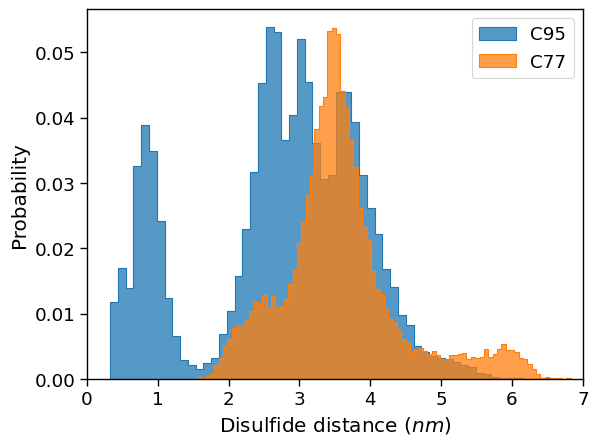

In [12]:
# make figure A

figname = 'figA'
fig = plt.figure()
sns.histplot(disulfide_1/10, element = 'step', stat='probability', label = 'C95')
sns.histplot(disulfide_2/10, element = 'step', stat='probability', label = 'C77')
plt.xlabel("Disulfide distance ($nm$)")
plt.xlim(0,7)
plt.legend()
plt.savefig(figure_path + f"{figname}.svg")
plt.savefig(figure_path + f"{figname}.pdf")
plt.savefig(figure_path + f"{figname}.png")

In [ ]:
torch.manual_seed(seed)
train_X, test_X = sk.model_selection.train_test_split(coords, test_size=.5) 
AE = Autoencoder(in_shape=coords.shape[1], enc_shape=2, middle_shape=1024, n_hidden=2, ortholoss=True,\
                 l2_reg=True) 
AE.fit(train_X, n_epochs=50, verbose=True)

In [ ]:
test = AE.transform(coords)
np.save(arr = test,file = project_path + f"AE_2layers_1024_enc_2_ortholoss_{seed}.npy")

In [13]:
test = np.load(file = project_path + f"AE_2layers_1024_enc_2_ortholoss_{seed}.npy" )

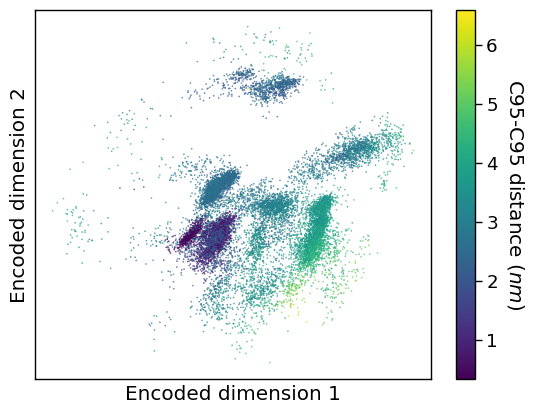

In [14]:
figname = 'figB'
figure_path = "/wrk/kaptan/projects/fgf2/figures/"
fig = plt.figure()
plt.scatter(test[:,0],test[:,1],s =0.1, c = disulfide_1/10)
cbar = plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel(f"Encoded dimension 1")
plt.ylabel(f"Encoded dimension 2")
cbar.set_label('C95-C95 distance ($nm$)', rotation=270, labelpad = 20)

plt.savefig(figure_path + f"{figname}.svg")
plt.savefig(figure_path + f"{figname}.pdf")
plt.savefig(figure_path + f"{figname}.png")

In [ ]:
# Unscaled train and test sets
scaler = StandardScaler().fit(test_X)
test_X_scaled = scaler.transform(test_X) 
# Scale test_X so we can call AE.transform on it. The transform method could also scale the input itself
test_encoded = AE.transform(test_X_scaled)
test_decoded = AE.inverse_transform(test_encoded)
test_error = reconstruction_error(test_X, test_decoded, scaler) 
# This function transforms the decoded representation back to the original space using "scaler"
print(test_error)

In [15]:
# do clustering

# define a grid of possible parameters
param_grid = {
    "n_components": range(1, 15),
    "covariance_type": [ "full"], #"spherical", "tied", "diag",
}

# intiate search with GMM as the model

grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(test)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['full'],
                         'n_components': range(1, 15)},
             scoring=<function gmm_bic_score at 0x7fdcc48b8d30>)

In [16]:
# plot the BIC scores

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score")
plt.plot(range(1,15),df['BIC score'])
plt.xlabel("Number of clusters")
plt.ylabel("BIC")
plt.xticks(range(1,15));

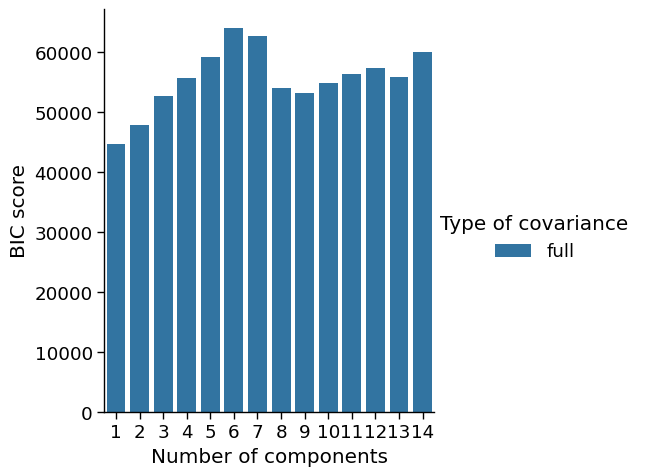

In [17]:
# plot the bar plot for the reported grid search

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)

In [18]:
# choose gmm
random_state = 0
n_clusters = 8
gmm = BayesianGaussianMixture(n_components=n_clusters, covariance_type='full',random_state=random_state,\
                      init_params='k-means++', max_iter=1000, reg_covar=1)
gmm.fit(X=test,)


BayesianGaussianMixture(init_params='k-means++', max_iter=1000, n_components=8,
                        random_state=0, reg_covar=1)

<Figure size 640x480 with 0 Axes>

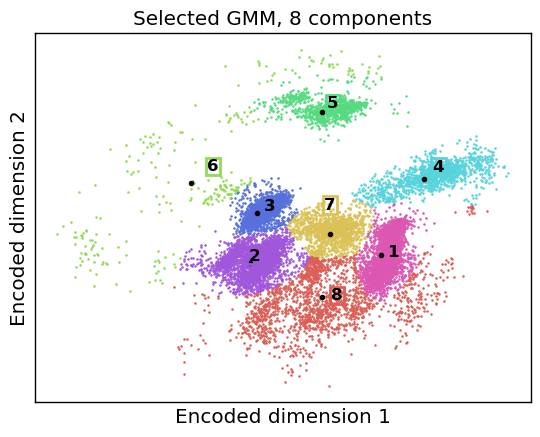

In [19]:
# plot the clusters 

figname = 'figC'

fig = plt.figure()
color_iter = sns.color_palette("hls", n_clusters)[::-1]
X = test
variance_label = 1
Y_ = gmm.predict(X)
selected_choices = []
choices = ((0,0),(0,variance_label),(0,-variance_label),(variance_label,0),\
           (-variance_label,0),(-variance_label,5),\
           (variance_label,-variance_label),(variance_label,variance_label))


#initialize an array to store the most representative samples

most_representative_samples = np.empty((n_clusters, test.shape[1]))
most_representative_index = np.empty(n_clusters)

# iterate over each cluster
for i in range(gmm.n_components):
    # get the samples assigned to the current cluster
    cluster_samples = X[Y_ == i]
    
    # compute the Mahalanobis distance of each sample to the mean of the current cluster
    distances = scp.spatial.distance.cdist(cluster_samples, gmm.means_[i].reshape(1, -1),\
                      metric='mahalanobis', VI=np.linalg.inv(gmm.covariances_[i]))
    
    # get the index of the sample with the smallest Mahalanobis distance to the mean of the current cluster
    min_index = np.argmin(distances)
    
    # store the most representative sample for the current cluster
    most_representative_samples[i] = cluster_samples[min_index]
    traj_index = np.where(X == most_representative_samples[i])
    most_representative_index[i] = np.array([traj_index[0][0]])

fig, ax = plt.subplots()

for i, (mean, cov, color) in enumerate(
    zip(
        #grid_search.best_estimator_.means_,
        #grid_search.best_estimator_.covariances_,
        gmm.means_,
        gmm.covariances_,
        color_iter,
    )
):
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], s=1, color=color,)
    rand  = random.sample(choices, 1)
    selected_choices.append(rand[0])
    plt.text(mean[0]+selected_choices[i][0],mean[1] + selected_choices[i][1],f"{i+1}",\
             fontsize = 12, weight='bold', color = 'black', \
             bbox = dict(facecolor='none', edgecolor=color, pad=1.0, lw = 2,) )
    plt.scatter(most_representative_samples[i].astype(int)[0], most_representative_samples[i].astype(int)[1],\
                s=10, color='k',)
    
plt.title(
    f"Selected GMM, "
    f"{n_clusters} components"
)
#plt.axis("equal")
#plt.xlim(-25,75)
plt.xticks([])
plt.yticks([])
plt.xlabel(f"Encoded dimension 1")
plt.ylabel(f"Encoded dimension 2")

plt.savefig(figure_path + f"{figname}.svg")
plt.savefig(figure_path + f"{figname}.pdf")
plt.savefig(figure_path + f"{figname}.png")

In [20]:
x_2_xlsx = pd.DataFrame(X)

x_2_xlsx.to_excel(figure_path+"main_data.xlsx", index=False)

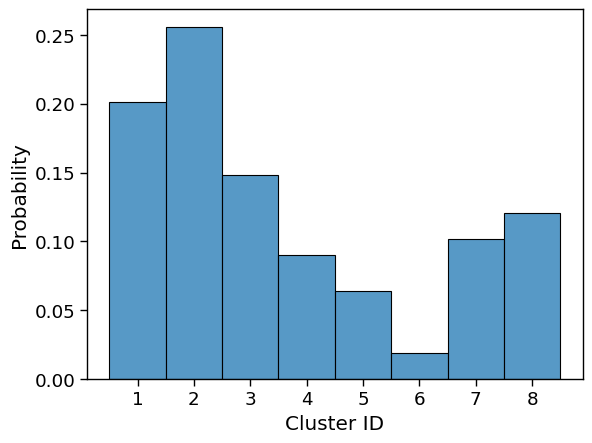

In [21]:
# populations per cluster
figname = 'figD'
fig = plt.figure()
n_clusters = len(gmm.means_)
sns.histplot(Y_,bins=range(n_clusters+1),stat='probability',)
plt.xticks(labels = range(1,n_clusters+1), ticks = np.arange(1,n_clusters+1)-0.5);
plt.xlabel("Cluster ID")
plt.savefig(figure_path + f"{figname}.svg")
plt.savefig(figure_path + f"{figname}.pdf")
plt.savefig(figure_path + f"{figname}.png")

# Use numpy to get the histogram bins and heights
heights, bins = np.histogram(Y_,bins=range(n_clusters+1), density = 1)

# Create a DataFrame from the bins and heights
hist_df = pd.DataFrame({'bins': bins[:-1], 'heights': heights})

# Write the DataFrame to an Excel file
hist_df.to_excel(figure_path + 'figD_histogram_data.xlsx', index=False)

In [22]:
# per cluster data

cluster_to_n_contacts={}
cluster_to_contacts={}
cluster_to_dist = {}
cluster_to_dis1 = {}
cluster_to_dis2 = {}

cut_off = 10

for entry in range(1, n_clusters+1):
    clust_label = 'Cluster '+str(entry)
    
    cluster_to_n_contacts[clust_label] = {}
    cluster_to_n_contacts[clust_label]['avg'] = 0
    cluster_to_n_contacts[clust_label]['std'] = 0
    cluster_to_n_contacts[clust_label]['x'] = np.array([])
    
    cluster_to_contacts[clust_label] = {}
    cluster_to_contacts[clust_label]['avg'] = np.zeros(contact_map.shape[1])
    cluster_to_contacts[clust_label]['std'] = np.zeros(contact_map.shape[1]) 
    
    cluster_to_dist[clust_label] = {}
    cluster_to_dist[clust_label]['avg'] = 0
    cluster_to_dist[clust_label]['std'] = 0
    cluster_to_dist[clust_label]['x'] = np.array([])
    
    cluster_to_dis1[clust_label] = {}
    cluster_to_dis1[clust_label]['avg'] = 0
    cluster_to_dis1[clust_label]['std'] = 0
    cluster_to_dis1[clust_label]['x'] = np.array([])
    
    cluster_to_dis2[clust_label] = {}
    cluster_to_dis2[clust_label]['avg'] = 0
    cluster_to_dis2[clust_label]['std'] = 0
    cluster_to_dis2[clust_label]['x'] = np.array([])


for index, cluster_ID in enumerate(Y_):
    clust_label = 'Cluster '+str(cluster_ID+1)

    n_contacts = len(contact_map[index][contact_map[index]<cut_off])
    cluster_to_n_contacts[clust_label]['avg'] += n_contacts
    cluster_to_n_contacts[clust_label]['std'] += n_contacts**2
    cluster_to_n_contacts[clust_label]['x'] = np.append(cluster_to_n_contacts[clust_label]['x'],n_contacts)
    
    min_dist = contact_map[index].min()
    cluster_to_dist[clust_label]['avg'] += min_dist
    cluster_to_dist[clust_label]['std'] += min_dist**2
    cluster_to_dist[clust_label]['x'] = np.append(cluster_to_dist[clust_label]['x'],min_dist)
    
    ds1 = disulfide_1[index]
    cluster_to_dis1[clust_label]['avg'] += ds1
    cluster_to_dis1[clust_label]['std'] += ds1**2
    cluster_to_dis1[clust_label]['x'] = np.append(cluster_to_dis1[clust_label]['x'],ds1)
    
    ds2 = disulfide_2[index]
    cluster_to_dis2[clust_label]['avg'] += ds2
    cluster_to_dis2[clust_label]['std'] += ds2**2
    cluster_to_dis2[clust_label]['x'] = np.append(cluster_to_dis2[clust_label]['x'],ds2)
    
    cluster_to_contacts[clust_label]['avg'] += contact_map[index]
    cluster_to_contacts[clust_label]['std'] += contact_map[index]**2
                       
    
for cluster_ID in range(0, n_clusters):  
    clust_label = 'Cluster '+str(cluster_ID+1)
    n_samples = len(Y_[Y_==cluster_ID])
    
    cluster_to_n_contacts[clust_label]['avg'] /= n_samples
    cluster_to_n_contacts[clust_label]['std']  = np.sqrt((cluster_to_n_contacts[clust_label]['std']/n_samples) - \
                                                    cluster_to_n_contacts[clust_label]['avg']**2 )
    
    cluster_to_dist[clust_label]['avg'] /= n_samples
    cluster_to_dist[clust_label]['std']  = np.sqrt((cluster_to_dist[clust_label]['std']/n_samples) - \
                                                    cluster_to_dist[clust_label]['avg']**2 )
    
    cluster_to_dis1[clust_label]['avg'] /= n_samples
    cluster_to_dis1[clust_label]['std']  = np.sqrt((cluster_to_dis1[clust_label]['std']/n_samples) - \
                                                    cluster_to_dis1[clust_label]['avg']**2 )
    
    cluster_to_dis2[clust_label]['avg'] /= n_samples
    cluster_to_dis2[clust_label]['std']  = np.sqrt((cluster_to_dis2[clust_label]['std']/n_samples) - \
                                                    cluster_to_dis2[clust_label]['avg']**2 )

    cluster_to_contacts[clust_label]['avg'] /= (n_samples*10) # change from ang to nm
    cluster_to_contacts[clust_label]['std']  = np.sqrt((cluster_to_contacts[clust_label]['std']/n_samples) - \
                                                    cluster_to_contacts[clust_label]['avg']**2 )/10

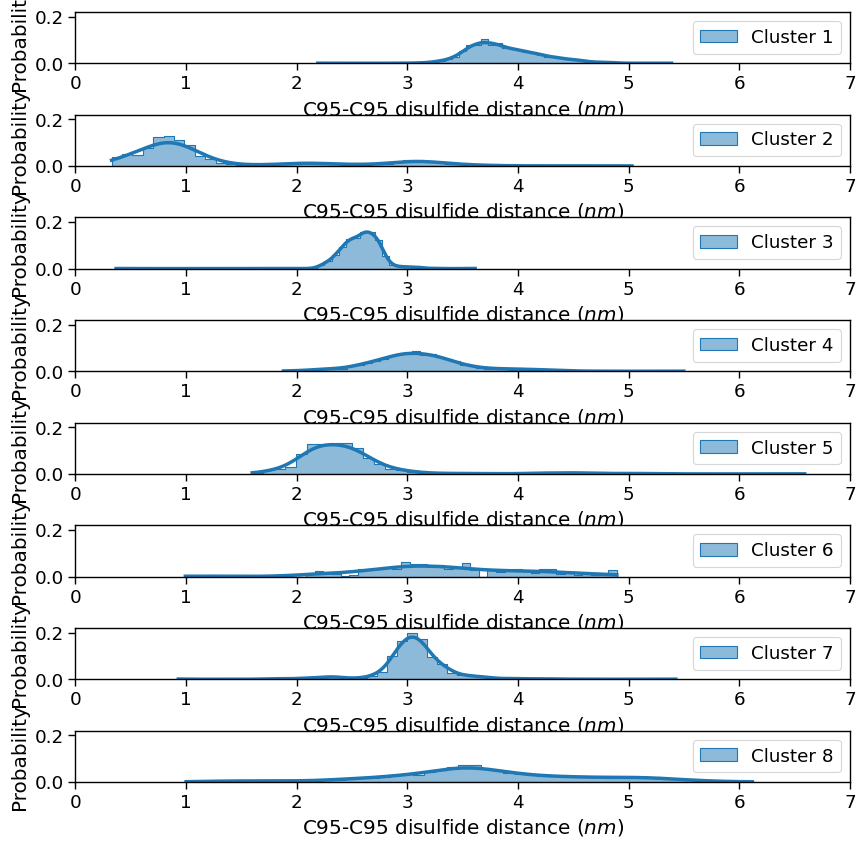

In [37]:
# cluster to Disulfide distance
figname = 'figF'
fig, axs = plt.subplots(len(cluster_to_dis1), \
                        facecolor='w', edgecolor='k',figsize = (10,10))
fig.subplots_adjust(hspace = 1, wspace=0.5)

#axes = axs.ravel()
for xindex, clust_ID in enumerate(cluster_to_dis1):
    data = pd.DataFrame.from_dict(cluster_to_dis1[clust_ID])
    sns.histplot(data=data, x=cluster_to_dis1[clust_ID]['x']/10, kde=True,ax=axs[xindex],\
                 bins=50,stat='probability', element = 'step', label = clust_ID)
    axs[xindex].set_xlabel("C95-C95 disulfide distance ($nm$)")
    #axs[xindex].set_title(clust_ID)
    axs[xindex].set_ylabel('Probability')
    
    axs[xindex].legend()
    if xindex<len(cluster_to_dis1)-1: 
        axs[xindex].xticks=[]
        axs[xindex].set_xlim(0,7)
    axs[xindex].set_xlim(0,7)
    axs[xindex].set_ylim(0,0.22)
plt.savefig(figure_path + f"{figname}.svg")
plt.savefig(figure_path + f"{figname}.pdf")
plt.savefig(figure_path + f"{figname}.png")

In [ ]:
#initialize an array to store the most representative samples

most_representative_samples = np.empty((n_clusters, test.shape[1]))
most_representative_index = np.empty(n_clusters)

# iterate over each cluster
for i in range(gmm.n_components):
    # get the samples assigned to the current cluster
    cluster_samples = X[Y_ == i]
    
    # compute the Mahalanobis distance of each sample to the mean of the current cluster
    distances = scp.spatial.distance.cdist(cluster_samples, gmm.means_[i].reshape(1, -1),\
                      metric='mahalanobis', VI=np.linalg.inv(gmm.covariances_[i]))
    
    # get the index of the sample with the smallest Mahalanobis distance to the mean of the current cluster
    min_index = np.argmin(distances)
    
    # store the most representative sample for the current cluster
    most_representative_samples[i] = cluster_samples[min_index]
    most_representative_index[i] = np.where(test == most_representative_samples[i])[0][0]

In [ ]:
# write out the representative structure for each cluster
results_path = f"{project_path}/{n_clusters}_bayes_full_{random_state}_2layers_{seed}/"
print(most_representative_index)
print(results_path)

if not exists(results_path): 
    !mkdir {results_path}


dimer_model = mda.Universe(data_path+"ref.pdb",dimer_path)

for f_index, ts in enumerate(dimer_model.trajectory):
    print(f"Currently on frame: {f_index}",end="\r")
    current_path = results_path + "cluster" + str(Y_[f_index]+1) + "/"
    if not exists(current_path): 
        !mkdir {current_path}
    dimer_model.atoms.write(current_path + f"frame{f_index}")
    if f_index in most_representative_index:
        cluster_ID = np.where(most_representative_index.astype(int) == f_index)[0] + 1 
        #print(cluster_ID)
        print(f"Current writing out representative structure for cluster {cluster_ID[0]+1}")
        print(f"For cluster {cluster_ID} the representative index is {f_index}")
        dimer_model.atoms.write(results_path + f"cluster{cluster_ID[0]+1}_representative")